**Student: Titouan Le Breton**

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd

# Exercise 1

### Question 1

To generate a random variable $Y$ taking values in $X = \{v_1, \dots, v_K\}$ with probabilities $(\pi_k)_{k=1}^K$, we first compute the partial sums $s_i = \sum_{k=1}^i \pi_k$, with $s_0 = 0$.  
We then draw $U \sim \mathcal{U}[0,1)$ and assign to $Y$ the value $v_i$ corresponding to the unique index $i$ such that $s_{i-1} \le U < s_i$.


### Question 2

In [2]:
def sample_pi(array_pi, array_v, N):
    # create the s_i
    array_pi_sum = np.cumsum(array_pi)
    array_pi_sum = np.insert(array_pi_sum, 0 ,0)

    # sample unfiormly
    array_u = np.random.rand(N)

    # find the 
    sampled_value = []
    for sample_u in array_u:
        for index_value in range(len(array_v)): # -1 beccause we added 0 at the beggining
            if array_pi_sum[index_value] <= sample_u < array_pi_sum[index_value + 1]:
                sampled_value.append(array_v[index_value])
                break
    
    return np.array(sampled_value)


In [3]:
array_pi = np.array([0.3, 0.2, 0.5])
array_v = np.array([-1, 2, 5])
N = 10

sample_pi(array_pi, array_v, N)

array([-1,  5,  5, -1,  5,  5,  5,  2,  5,  5])

### Question 3

In [4]:
array_v = np.array([-3, -1, 0, 1, 2, 3, 4, 5, 7, 10])
array_pi = np.array([0.05, 0.10, 0.08, 0.07, 0.10, 0.15, 0.10, 0.05, 0.15, 0.15])
N = 1000

array_sample_v = sample_pi(array_pi, array_v, N)

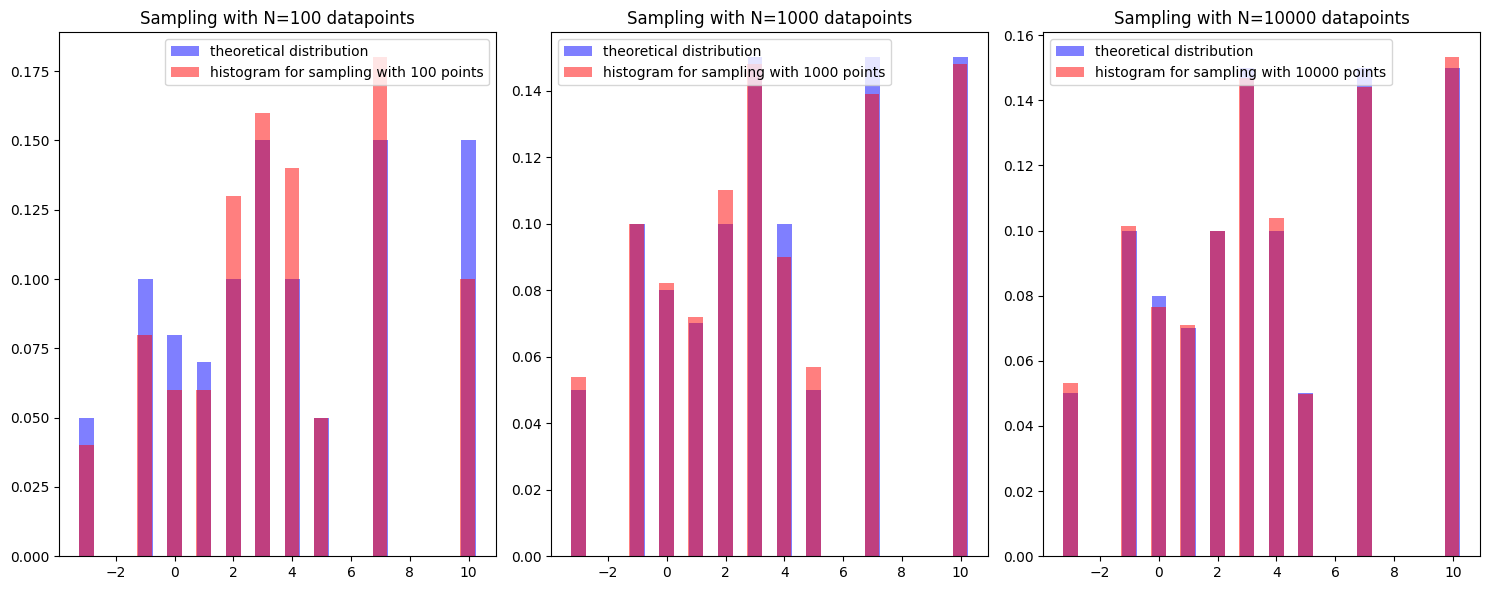

In [5]:
def plot_empirical_vs_theoretical(array_pi, array_v, N, sample_pi, ax):
    #Sample
    array_sample_v = sample_pi(array_pi, array_v, N)

    #format for plotting
    bins = np.arange(min(array_v) - 0.4, max(array_v) + 0.8, 0.8)
    counts, bins = np.histogram(array_sample_v, bins=500)
    heights = counts / counts.sum()

    ax.bar(array_v, array_pi, color="blue", alpha=0.5, label="theoretical distribution", width=0.5)
    ax.bar(bins[:-1], heights, width=0.5, color="red", alpha=0.5, label=f"histogram for sampling with {N} points")
    ax.set_title(f"Sampling with N={N} datapoints")
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, N in zip(axes, [int(1e2), int(1e3), int(1e4)]):
    plot_empirical_vs_theoretical(array_pi, array_v, N, sample_pi, ax)

plt.tight_layout()
plt.show()

**Observations**: as N increases, the distribution of sampled data gets closer to the empirical distribution. This is no surprise: it is the law of large numbers.

# Exercise 2

### Question 1

For a given data point $x_i$, we have: $$ f_\theta(x_i) \;=\; \sum_{j=1}^m p_\alpha(Z_i=j)\; p_{\mu_j,\Sigma_j}(x_i \mid Z_i=j)
\;=\; \sum_{j=1}^m \alpha_j \;\mathcal N(x_i \mid \mu_j,\Sigma_j). $$

With $p_\alpha(Z_i=j)=\alpha_j$,, and:
$$
\mathcal N(x \mid \mu_j,\Sigma_j)
= \frac{1}{(2\pi)^{d/2}|\Sigma_j|^{1/2}}
\exp\!\left(-\tfrac12 (x-\mu_j)^\top \Sigma_j^{-1}(x-\mu_j)\right).
$$

For i.i.d. data $x_1,\dots,x_n$,
$$
L(x_1,\dots,x_n;\theta)
= \prod_{i=1}^n f_\theta(x_i)
= \prod_{i=1}^n \sum_{j=1}^m \alpha_j \,\mathcal N(x_i \mid \mu_j,\Sigma_j).
$$

Therefore, the parameters $theta$ are:
$$
\theta \;=\; (\alpha_1,\dots,\alpha_m,\; \mu_1,\dots,\mu_m,\; \Sigma_1,\dots,\Sigma_m)
$$

We also notice that the log-likelihood is:
$
\ell(\theta)
= \sum_{i=1}^n \log\!\left(\sum_{j=1}^m \alpha_j \,\mathcal N(x_i \mid \mu_j,\Sigma_j)\right).
$
, which is aobjective is non-convex function (sum of a log of sums), so EM is required


### Question 2

Python. First you sample the Z (reuse the code form the first exercise), then you sampling the gaussian varainces. 

In [22]:
# Defining the parameters of the distribution

K_clusters = 3

alpha_array = np.array([3/10, 2/10, 5/10])
z_array = np.array([0, 1, 2])

mu_array = np.array([
    [-2,0],
    [3,1],
    [2,-1]
])

sigma_1 = np.array([
    [0.2, 0],
    [0, 0.1]
])

sigma_2 = np.array([
    [0.5, 0.2],
    [0.2, 0.4]
])

sigma_3 = np.array([
    [0.5, -0.2],
    [-0.2, 0.7]
])

sigma_matrix = np.stack([sigma_1, sigma_2, sigma_3], axis=0)

In [23]:
N_samples = 200

def sample(alpha_array, z_array, mu_array, sigma_matrix, N_samples):
    # Sample z, the class
    z_samples_array = sample_pi(alpha_array, z_array, N_samples)

    # Sample x, the datapoint 
    X = np.ones((N_samples, mu_array.shape[1]))
    for z_i in z_array:
        z_mask = z_samples_array == z_i
        z_n = z_mask.sum()
        X[z_mask] = np.random.multivariate_normal(mean = mu_array[z_i], cov=sigma_matrix[z_i], size=z_n)
    
    # return the sampled point, but also the class that it comes from
    return X, z_samples_array

X_samples_array, z_samples_array = sample(alpha_array, z_array, mu_array, sigma_matrix, N_samples)

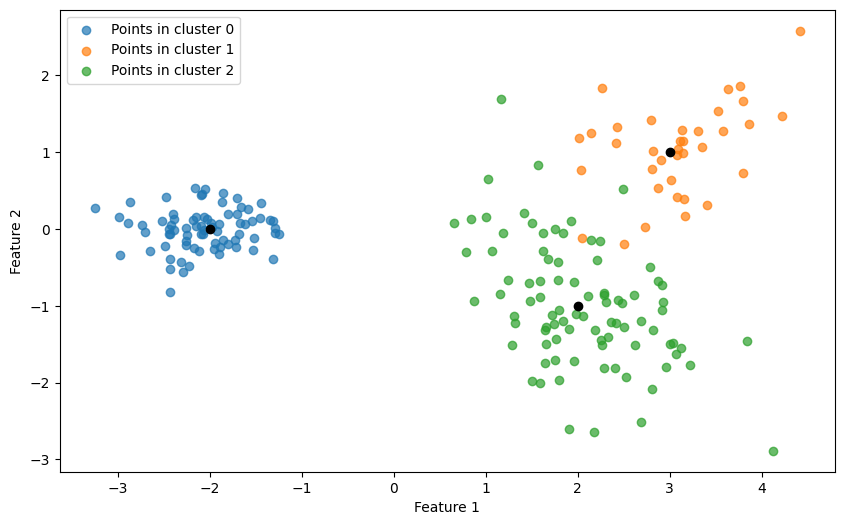

In [24]:
def plot_GMM(X_samples_array, z_samples_array, z_array, mu_array=None):
    plt.figure(figsize=(10,6))
    for z_i in z_array:
        z_mask = z_samples_array == z_i
        plt.scatter(X_samples_array[z_mask, 0], X_samples_array[z_mask, 1], label=f"Points in cluster {z_i}", alpha=0.7)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
    if mu_array is not None:
        plt.scatter(mu_array[:,0], mu_array[:,1], color="black")
    plt.show()

plot_GMM(X_samples_array, z_samples_array, z_array, mu_array=mu_array)

### Question 3


The computational steps for implementing the EM algorithm in the context of GMM are the following:

I. E-step

We compute the responsibilities (posterior probabilities):

$$
\gamma_{ik}^{(t)} = P(z_i = k \mid x_i, \theta^{(t)}) =
\frac{\alpha_k^{(t)} \, \mathcal{N}(x_i \mid \mu_k^{(t)}, \Sigma_k^{(t)})}
{\sum_{j=1}^m \alpha_j^{(t)} \, \mathcal{N}(x_i \mid \mu_j^{(t)}, \Sigma_j^{(t)})}.
$$



II. M-step

We update the parameters using these responsibilities.

First, define:

$$
N_k^{(t)} = \sum_{i=1}^{N\_samples} \gamma_{ik}^{(t)}.
$$

Then update:

$$
\alpha_k^{(t+1)} = \frac{N_k^{(t)}}{N\_samples}, \quad
\mu_k^{(t+1)} = \frac{1}{N_k^{(t)}} \sum_{i=1}^{N\_samples} \gamma_{ik}^{(t)} x_i,
$$

$$
\Sigma_k^{(t+1)} = \frac{1}{N_k^{(t)}} \sum_{i=1}^{N\_samples} \gamma_{ik}^{(t)} (x_i - \mu_k^{(t+1)})(x_i - \mu_k^{(t+1)})^\top.
$$


In [25]:
# alpha_t_array = np.ones(K_clusters) / K_clusters

# indices = np.random.choice(N_samples, K_clusters, replace=False)
# mu_t_array = X_samples_array[indices]

# # OLD (wrong shape): sigma_t_matrix = np.cov(X_samples_array, rowvar=False)

# # NEW: one covariance matrix per class
# emp_cov = np.cov(X_samples_array, rowvar=False)
# sigma_t_matrix = np.stack([emp_cov.copy() for _ in range(K_clusters)])

# gamma_t_array = compute_gamma(X_samples_array, alpha_t_array, mu_t_array, sigma_t_matrix)

# alpha_t_1_array = compute_alpha(gamma_t_array)

# mu_t_1_array = compute_mu(X_samples_array, gamma_t_array)

We start by defining the functions for computing the parameters and estimating the variables at different steps of the EM algorithm:

In [26]:
# E-step funcitons
# -------------------------------------------------------

def compute_gamma(X_samples_array, alpha_t_array, mu_t_array, sigma_t_matrix):
    # X_samples_array of shape (N_samples, dim)
    # alpha_t_array of shape (K_clusters)
    # mu_t_array of shape (K_clusters, dim)
    # sigma_t_matrix of shape (K_clusters, dim, dim)

    N_samples = X_samples_array.shape[0]
    K_clusters = alpha_t_array.shape[0]
    gamma_t_array = np.zeros((N_samples, K_clusters))
    for k in range(K_clusters):
        gamma_t_array[:, k] = alpha_t_array[k] * multivariate_normal.pdf(X_samples_array, mean=mu_t_array[k], cov=sigma_t_matrix[k])

    return gamma_t_array / gamma_t_array.sum(axis=1, keepdims=True) # of shape (N_samples, K_clusters)


# M-step funcitons
# --------------------------------------------------------

def compute_alpha(gamma_t_array):
    # gamma_t_array of shape (N_samples, K_clusters)
    N_samples, K_clusters = gamma_t_array.shape
    alpha_t_1_array = gamma_t_array.sum(axis=0) / N_samples
    return alpha_t_1_array  # of shape (K_clusters)
    

def compute_mu(X_samples_array, gamma_t_array):
    # X_samples_array of shape (N_samples, dim)
    # gamma_t_array of shape (N_samples, K_clusters)

    # print(f"X_samples_array shape: {X_samples_array.shape}")
    # print(f"gamma_t_array shape: {gamma_t_array.shape}")

    N_t = gamma_t_array.sum(axis=0).reshape(-1,1) # shape (K_clusters, 1)
    #print(f"N_t shape: {N_t.shape}")
    mu_t_1_array = (gamma_t_array.T @ X_samples_array) / N_t

    #print(f"mu_t_1_array: {mu_t_1_array.shape}")

    return mu_t_1_array #shape (K_clusters, dim)
    

def compute_sigma(X_samples_array, mu_t_1_array, gamma_t_array):
    # gamma_t_array of shape (N_samples, K_clusters)
    # mu_t_1_array of shape (K_clusters, dim)
    # X_samples_array of shape (N_samples, dim)

    N_samples, K_clusters = gamma_t_array.shape
    dim = X_samples_array.shape[1] 

    sigma_t_1_matrix = np.ones((K_clusters, dim, dim))

    for k in range(K_clusters):
        # We compute N_t_k, diagonalise the gamma terms and compute a centered data matrix for efficent matrix-wise computation of sigma_k
        N_t_k = gamma_t_array[:,k].sum()
        if N_t_k!= 0:
            diagonal_gamma = np.diag(gamma_t_array[:,k])
            X_centered = X_samples_array - mu_t_1_array[k].reshape(1,-1)
            
            sigma_t_1_matrix[k] = (X_centered.T @ diagonal_gamma @ X_centered) / N_t_k

    return sigma_t_1_matrix



### For compute log_likelihood
def compute_log_likelihood(X_samples_array, alpha_array, mu_array, sigma_matrix):
    # X_samples_array of shape (N_samples, dim)
    # alpha_array of shape (K_clusters)
    # mu_array of shape (K_clusters, dim)
    # sigma_matrix of shape (K_clusters, dim, dim)

    N_samples, dim = X_samples_array.shape
    K_clusters = alpha_array.shape[0]

    # build the log_likelihood matrix for efficent computation
    log_likelihood_matrix = np.zeros((N_samples, K_clusters))
    for k in range (K_clusters):
        log_likelihood_matrix[:,k] = alpha_array[k] * multivariate_normal.pdf(X_samples_array, mean=mu_array[k], cov=sigma_matrix[k])

    # take the sum along the clusters, then the log, and return the sum along the samples
    log_likelihood_matrix = np.log(log_likelihood_matrix.sum(axis=1))

    return log_likelihood_matrix.sum(axis=0)


Then we define a function to run the EM algorithm:

Text(0, 0.5, 'log-likelihood')

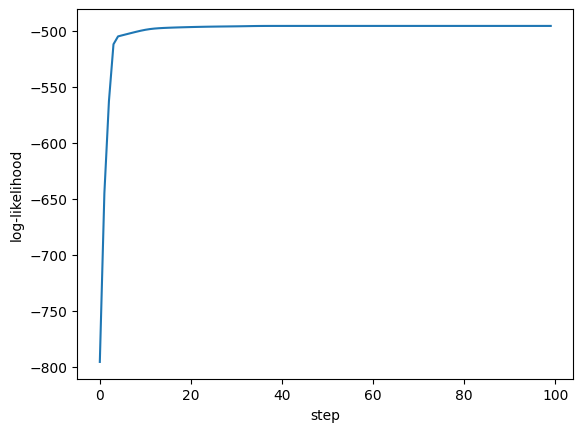

In [ ]:
def run_EM(X_samples_array, z_array, n_steps = 100):
    # X_samples_array of shape (N_samples, dim)
    # z_array of shape K_clusters

    N_samples, dim = X_samples_array.shape
    K_clusters = len(z_array)

    # we initalise our parameters at random
    alpha_t_array = np.ones(K_clusters) / K_clusters
    indices = np.random.choice(N_samples, K_clusters, replace=False)
    mu_t_array = X_samples_array[indices]
    emp_cov = np.cov(X_samples_array, rowvar=False)
    sigma_t_matrix = np.stack([emp_cov.copy() for _ in range(K_clusters)])
    list_log_likelihood = []


    for i in range(n_steps):
        # E step
        gamma_t_array = compute_gamma(X_samples_array, alpha_t_array, mu_t_array, sigma_t_matrix)

        # We compute and save the log-likelihh
        list_log_likelihood.append(compute_log_likelihood(X_samples_array, alpha_t_array, mu_t_array, sigma_t_matrix))

        # M step
        alpha_t_1_array = compute_alpha(gamma_t_array)
        mu_t_1_array = compute_mu(X_samples_array, gamma_t_array)
        sigma_t_1_matrix = compute_sigma(X_samples_array, mu_t_1_array, gamma_t_array)
        


        alpha_t_array, mu_t_array, sigma_t_matrix = alpha_t_1_array, mu_t_1_array, sigma_t_1_matrix


    return alpha_t_array, mu_t_array, sigma_t_matrix, list_log_likelihood


alpha_t_array, mu_t_array, sigma_t_matrix, list_log_likelihood = run_EM(X_samples_array, z_array, n_steps = 100)


plt.figure()
plt.plot(range(len(list_log_likelihood)), list_log_likelihood)
plt.xlabel("step")
plt.ylabel("log-likelihood")

**observation:** Our log-likelihood increases sharply in the early steps, meaning there is a significant improvement in the estimated paramters. However, beyond 20 steps, the log-likelihood reaches an upper limit and no further improvments result from the computation

### Question 4

In [ ]:
raise RuntimeError("DO NOT RERUN OR YOU WILL HAVE TO REDEFINE THE REINDEXES")

In [ ]:
# we re-order because there is no reason for the clusters to be in the right order
index_order = np.array([1, 0, 2])
alpha_t_array = alpha_t_array[index_order]
mu_t_array = mu_t_array[index_order]
sigma_t_matrix = sigma_t_matrix[index_order]

In [51]:
print(f"distance on alpha: {np.linalg.norm(alpha_t_array - alpha_array)}") 
print(f"distance on mu: {np.linalg.norm(mu_t_array - mu_array)}")
print(f"distance on sigma: {np.linalg.norm(sigma_t_matrix - sigma_matrix)}\n")


print("Estimated alphas:\n", alpha_t_array)
print("\nOriginal alphas:\n", alpha_array) 
print("\nEstimated mu:\n", mu_t_array)
print("\nOriginal mu:\n", mu_array)
print("\nEstimated sigma:\n", sigma_t_matrix)
print("\nOriginal sigmas:\n", sigma_matrix)


distance on alpha: 0.10027830735407033
distance on mu: 0.13346052307798875
distance on sigma: 0.21679550321323907

Estimated alphas:
 [0.37999986 0.17509595 0.44490418]

Original alphas:
 [0.3 0.2 0.5]

Estimated mu:
 [[-2.06964811 -0.00631141]
 [ 3.07692623  1.06776131]
 [ 2.04566573 -0.98193291]]

Original mu:
 [[-2  0]
 [ 3  1]
 [ 2 -1]]

Estimated sigma:
 [[[ 0.19380421  0.00959796]
  [ 0.00959796  0.0706278 ]]

 [[ 0.3724958   0.13696248]
  [ 0.13696248  0.29717035]]

 [[ 0.45689107 -0.24488142]
  [-0.24488142  0.62754895]]]

Original sigmas:
 [[[ 0.2  0. ]
  [ 0.   0.1]]

 [[ 0.5  0.2]
  [ 0.2  0.4]]

 [[ 0.5 -0.2]
  [-0.2  0.7]]]


**observation:** Overall, as the linalg norm shows, performance is good and we find parameters similar to the real ones. It is on the alpha where, when comparing the index values between the estimated and the real value, we notice there is the highest difference.

### Question 5

You have to download the data yourself, but you also have to, like, select the columns and clean it.

In [58]:
import_data_pd = pd.read_csv(r"C:\Users\titou\Desktop\cours_MVA\computational_statistics\WPP2024_Demographic_Indicators_Medium.csv\WPP2024_Demographic_Indicators_Medium.csv")
import_data_pd[["CBR", "CDR"]].describe()

C:\Users\titou\AppData\Local\Temp\ipykernel_20552\1883871733.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  import_data_pd = pd.read_csv(r"C:\Users\titou\Desktop\cours_MVA\computational_statistics\WPP2024_Demographic_Indicators_Medium.csv\WPP2024_Demographic_Indicators_Medium.csv")


,CBR,CDR
count,83805.000000,83805.000000
mean,20.855080,10.927942
std,12.855018,4.701542
min,2.467000,0.841000
25%,10.341000,7.670000
50%,16.132000,9.984000
75%,29.125000,12.932000
max,58.627000,153.963000


<Axes: title={'center': 'scatter plot of CBR vs CDr'}, xlabel='CBR', ylabel='CDR'>

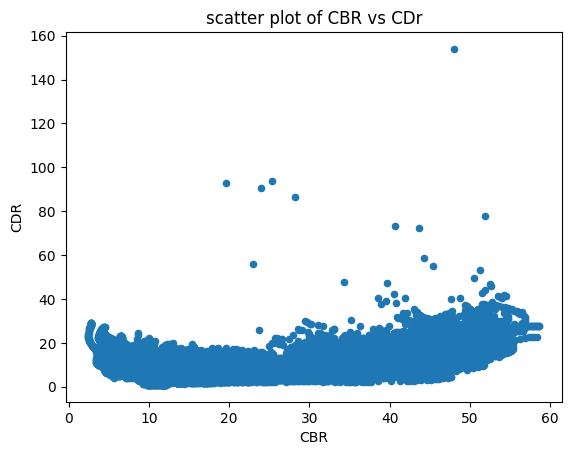

In [ ]:
import_data_pd.plot(kind="scatter", x="CBR", y="CDR", title="scatter plot of CBR vs CDR")

**Observation**: The scatter plots show that this is a case in which clustering is not the intuitive approach: there seems to be no separation of the data. However, if we want to do clustering, then using a GMM seems like the best choice. There are no ‘clear-cut’ boundaries in this data, so a deterministic approach like K-means or HAC is unlikely to provide good results. GMM is able to model uncertainty, so it seems like the best approach for clustering.